In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm
import koreanize_matplotlib

# 폰트 경로 확인 및 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)


# 한글 깨짐 방지 - 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

#### 포인트가 많은 유저(또는 많이 받은 유저)는 실제로 더 많이 투표하는가?

/tmp/ipykernel_2900256/842186427.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  point_bin_stats = user_point_activity.groupby('point_level')['vote_count'].mean().reset_index()


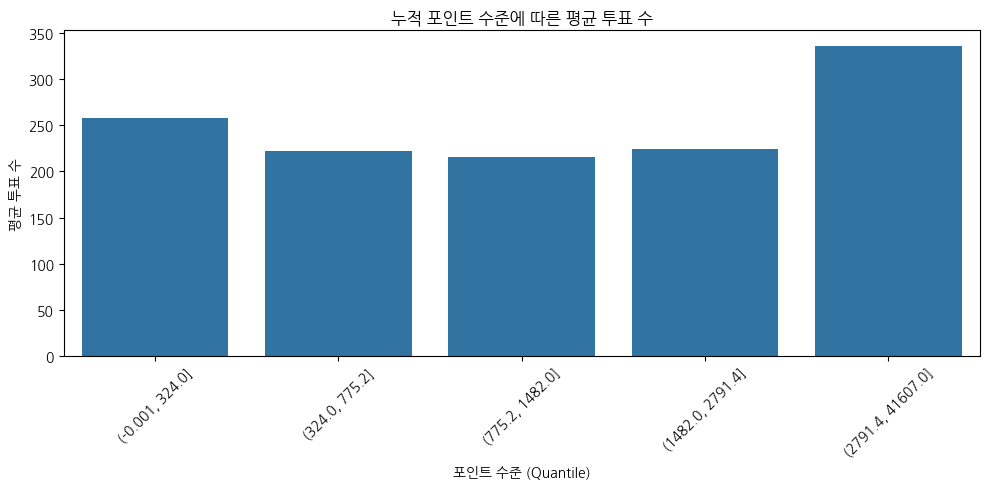

,point_level,vote_count
0,"(-0.001, 324.0]",257.735324
1,"(324.0, 775.2]",221.611971
2,"(775.2, 1482.0]",215.408247
3,"(1482.0, 2791.4]",224.721362
4,"(2791.4, 41607.0]",335.931959


In [2]:
# 1. 유저 정보 (누적 point)
user_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/accounts_user.parquet")[['id', 'point']]
user_df = user_df.rename(columns={'id': 'user_id'})

# 2. 유저별 투표 수 집계
vote_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/accounts_userquestionrecord.parquet")
user_vote_count = vote_df.groupby('user_id').size().reset_index(name='vote_count')

# 3. 병합
user_point_activity = user_vote_count.merge(user_df, on='user_id', how='left')

# 4. 포인트 구간 나누기

user_point_activity['point_level'] = pd.qcut(user_point_activity['point'], q=5, duplicates='drop')

# 5. 구간별 평균 투표 수
point_bin_stats = user_point_activity.groupby('point_level')['vote_count'].mean().reset_index()

# 6. 시각화


plt.figure(figsize=(10, 5))
sns.barplot(data=point_bin_stats, x='point_level', y='vote_count')
plt.xticks(rotation=45)
plt.title('누적 포인트 수준에 따른 평균 투표 수')
plt.xlabel('포인트 수준 (Quantile)')
plt.ylabel('평균 투표 수')
plt.tight_layout()
plt.show()

point_bin_stats

포인트가 매우 높은 유저는 확실히 활발          
➡ 포인트는 결과(보상)이자 행동의 간접 지표로 볼 수 있음

/tmp/ipykernel_2900256/1251701329.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data=user_activity.groupby('reward_level')['vote_count'].mean().reset_index(),


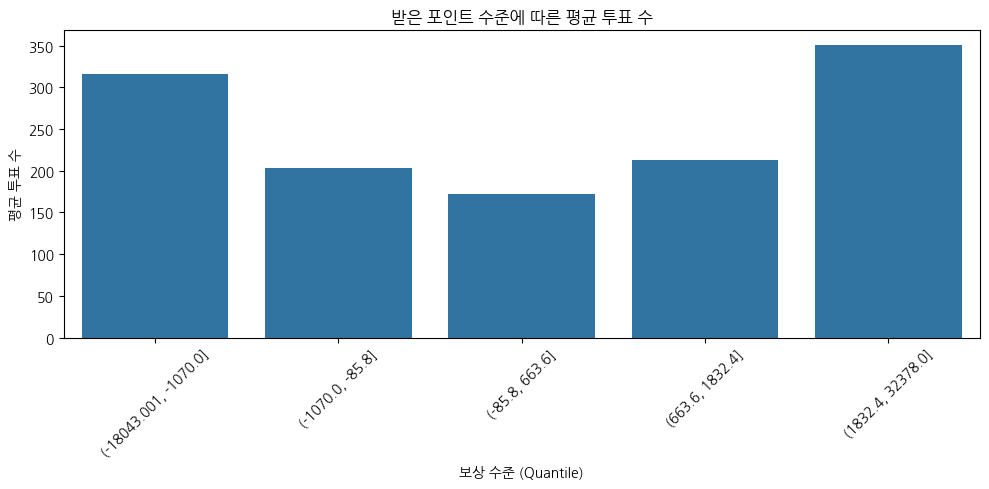

,user_id,vote_count,total_reward,reward_level
0,838023,22,1065,"(663.6, 1832.4]"
1,838466,131,948,"(663.6, 1832.4]"
2,838642,10,44,"(-85.8, 663.6]"
3,839357,212,1348,"(663.6, 1832.4]"
4,840293,170,2989,"(1832.4, 32378.0]"
...,...,...,...,...
4844,1577440,23,3325,"(1832.4, 32378.0]"
4845,1578095,33,563,"(-85.8, 663.6]"
4846,1579418,49,488,"(-85.8, 663.6]"
4847,1580578,2,10,"(-85.8, 663.6]"


In [3]:
# pointhistory에서 유저별 받은 포인트 합계
point_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/accounts_pointhistory.parquet")
delta_sum = point_df.groupby('user_id')['delta_point'].sum().reset_index(name='total_reward')

# 유저별 투표 수와 병합
user_activity = vote_df.groupby('user_id').size().reset_index(name='vote_count')
user_activity = user_activity.merge(delta_sum, on='user_id', how='left')

# 포인트 수령 수준별 그룹화
user_activity['reward_level'] = pd.qcut(user_activity['total_reward'].fillna(0), q=5)

# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(data=user_activity.groupby('reward_level')['vote_count'].mean().reset_index(),
            x='reward_level', y='vote_count')
plt.title('받은 포인트 수준에 따른 평균 투표 수')
plt.xlabel('보상 수준 (Quantile)')
plt.ylabel('평균 투표 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

user_activity

- 보상을 많이 받은 유저는 명확히 활발함
- 음수 보상 유저 중에도 투표 많이 한 사례 존재 → 추가 규칙 기반 제재 가능성 있음

### 성별에 따른 활동 및 리텐션 차이

In [24]:


# GCS base path
base_path = "gs://final_project_enuyu/data/final_project/votes/"

# 1. 테이블 불러오기
point_df = pd.read_parquet(base_path + "accounts_pointhistory.parquet")
record_df = pd.read_parquet(base_path + "accounts_userquestionrecord.parquet")
user_df = pd.read_parquet(base_path + "accounts_user.parquet")

# 2. 투표 기록과 포인트 데이터 병합 (투표자/선택자 정보 확보)
df = point_df.merge(
    record_df[['id', 'user_id', 'chosen_user_id']],
    left_on='user_question_record_id', right_on='id', how='left'
)

# 3. 컬럼 정리
df.rename(columns={
    'user_id': 'user_id_x',   # 포인트 테이블의 유저 ID
    'user_id_x': 'user_id',   # 투표자 ID로 다시 명확히 설정
}, inplace=True)

df.drop(columns=['id'], inplace=True, errors='ignore')  # 중복 컬럼 제거

# 4. 유저 테이블 ID 정리
user_df = user_df.rename(columns={'id': 'user_id'})

# 5. 투표자 성별 병합
df = df.merge(
    user_df[['user_id', 'gender']].rename(columns={'gender': 'gender_voter'}),
    on='user_id', how='left'
)

# 6. 선택자 성별 병합
df = df.merge(
    user_df[['user_id', 'gender']].rename(columns={'user_id': 'chosen_user_id', 'gender': 'gender_chosen'}),
    on='chosen_user_id', how='left'
)

# 7. 최종 컬럼 확인
print(df[['user_id', 'gender_voter', 'chosen_user_id', 'gender_chosen', 'delta_point']].head())


   user_id gender_voter  chosen_user_id gender_chosen  delta_point
0   849436            F        849469.0             F            9
1   849436            F        849446.0             F            9
2   849436            F        849454.0             F            5
3   849436            F        847375.0             F           13
4   849436            F        849477.0             M            5


#### 성별별 투표 수 및 평균 포인트

In [25]:
# 투표자 성별 기준
voter_summary = df.groupby("gender_voter")["delta_point"].agg(['count', 'mean']).reset_index()
voter_summary.rename(columns={'count': 'vote_count', 'mean': 'avg_point'}, inplace=True)
print(voter_summary)


  gender_voter  vote_count  avg_point
0            F     1271168   0.793276
1            M     1067750   0.941815


- 여성: 참여자 수 많음, 활동당 보상은 낮음
- 남성: 참여수 적지만 보상(활동성)이 높음

- 여성 유저가 투표 활동에 더 많이 참여하고 있음. 여성 유저가 전체 투표 활동의 약 54.3%를 차지
- 하지만 남성 유저는 투표 1회당 평균 delta_point가 더 높아, 행동당 효율이 높다고 해석 가능.
- 이는 여성의 리텐션이 더 높을 가능성을 뒷받침할 수 있음 (지속적인 참여).
- 반대로 남성 유저는 선택적으로 더 강한 행동을 보일 가능성도 있음.

#### 선택자 성별 기준

In [26]:
# 선택된 유저 성별 기준
chosen_summary = df.groupby("gender_chosen")["delta_point"].agg(['count', 'mean']).reset_index()
chosen_summary.rename(columns={'count': 'chosen_count', 'mean': 'avg_point_received'}, inplace=True)
print(chosen_summary)


  gender_chosen  chosen_count  avg_point_received
0             F       1280978            0.628083
1             M       1054948            0.303297


- 여성 유저가 더 많이 선택되고, 선택될 때마다 더 많은 delta_point를 받음              
→ 인기/호감도 높음 또는 더 많은 참여를 이끌어내는 콘텐츠 성향일 수 있음.  
- 여성 유저가 남성보다 더 자주 선택되며 평균 보상도 약 2배 높음            
- 남성 유저는 선택 빈도도 낮고, 보상도 낮아 상대적으로 리텐션 유도가 약할 수 있음

#### 성별 매칭 조합 (투표자 → 선택자)

In [27]:
# 투표자 → 선택자 조합별 활동 분석
match_summary = df.groupby(["gender_voter", "gender_chosen"])["delta_point"].agg(['count', 'mean']).reset_index()
match_summary.rename(columns={'count': 'pair_count', 'mean': 'avg_point'}, inplace=True)
print(match_summary)


  gender_voter gender_chosen  pair_count  avg_point
0            F             F     1105207  -0.859875
1            F             M      164840   9.980442
2            M             F      175771   9.984013
3            M             M      890108  -1.488823


- 이성 투표(F→M, M→F)는 보상이 높고 긍정적
→ 투표자-선택자 간 긍정 반응 유도 또는 소셜 호감도 높은 질문일 가능성                      
                                
- 동성 투표(F→F, M→M)는 보상이 음수
→ 감정적인 투표, 비판, 혹은 소극적 참여로 인한 스킵 가능성                                

- 여성 유저들 사이에서 가장 많은 상호작용이 있지만 보상이 가장 낮음
→ 지속적인 참여는 많지만 효율성은 낮을 수 있음                     

#### 초대받은 유저들의 리텐션

In [4]:


# GCS 경로
base_path = "gs://final_project_enuyu/data/final_project/votes/"
tables = {}

# 필요한 테이블 로드
for name in [
    "accounts_friendrequest",
    "accounts_userquestionrecord",
    "polls_questionpiece",
    "accounts_user"
]:
    key = name.split("_")[-1]  # 간단 키: friendrequest → friend 등
    tables[key] = pd.read_parquet(f"{base_path}{name}.parquet", engine="pyarrow")

# 테이블 변수
friend_df = tables["friendrequest"]
vote_df = tables["userquestionrecord"]
piece_df = tables["questionpiece"]
user_df = tables["user"]

# 1. 수락된 친구 요청
accepted_df = friend_df[friend_df["status"] == "A"]
accepted_users = accepted_df["receive_user_id"].unique()

# 2. 초대받은 유저의 기록
invited_votes = vote_df[vote_df["user_id"].isin(accepted_users)]

# 3. question_piece_id 기준으로 is_voted 가져오기
invited_votes = invited_votes.copy()
invited_votes["question_piece_id"] = invited_votes["question_piece_id"].astype(str)
piece_df["id"] = piece_df["id"].astype(str)

merged_votes = invited_votes.merge(
    piece_df[["id", "is_voted"]],
    left_on="question_piece_id", right_on="id", how="left"
)

# 4. 응답률 계산
vote_rate = merged_votes["is_voted"].mean()

# 5. 리텐션 계산 (가입일 기준 단순 경과일)
user_df = user_df.rename(columns={"id": "user_id"})
retention_df = user_df[["user_id", "created_at"]].copy()
retention_df["retention_days"] = (pd.Timestamp("2023-08-01") - pd.to_datetime(retention_df["created_at"])).dt.days

# 6. 초대받은 유저들의 리텐션
invited_retention = retention_df[retention_df["user_id"].isin(accepted_users)]
avg_retention = invited_retention["retention_days"].mean()

print("응답률:", vote_rate)
print("평균 리텐션:", avg_retention)


응답률: 1.0
평균 리텐션: 78.24063613948825


- 참여 유도 효과: 초대를 수락한 유저는 매우 높은 응답률(=활동 참여)을 보임
- 장기 리텐션: 단기 방문이 아닌, 지속적으로 플랫폼에 머문 경향
- 초대 기능의 가치 있음 → 사용자 확보 및 활성화 전략으로 적극 고려 가능

